In [3]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
# The model that we'll use is MobileNet v2 (but any model from tf2 compatible image classifier URL from tfhub.dev would work).

CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

65536/61306 [================================] - 0s 0us/step


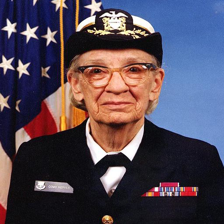

In [6]:
import numpy as np
import PIL.Image as Image

# ImageNet has 1000 different output classes, and one of them is military uniforms. 
# Let's get an image containing a military uniform that is not part of ImageNet.
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
# Remember, models always want a batch of images to process. 
# add a batch dimension, and pass the image to the model for prediction

result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
# result is a 1001 element vector of logits
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

16384/10484 [==============================================] - 0s 0us/step


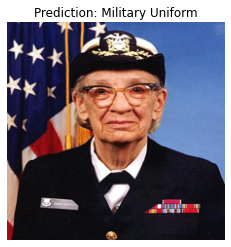

In [10]:
# download the ImageNet labels and fetch the row that the model predicted

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [11]:
# Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFRJ66V/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
# Note dataset are not all the same size
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [13]:
# MobileNet is (224, 224)
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'Egyptian cat', 'tabby', 'sleeping bag', 'bloodhound',
       'Persian cat', 'Siamese cat', 'tabby', 'beagle', 'lynx',
       'Labrador retriever', 'Rottweiler', 'Angora', 'Siamese cat',
       'Labrador retriever', 'bluetick', 'Japanese spaniel', 'Cardigan',
       'Siamese cat', 'bull mastiff', 'miniature pinscher', 'Great Dane',
       'kelpie', 'Persian cat', 'Egyptian cat', 'tabby', 'dingo',
       'wire-haired fox terrier', 'lynx', 'schipperke', 'tabby', 'tabby'],
      dtype='<U30')

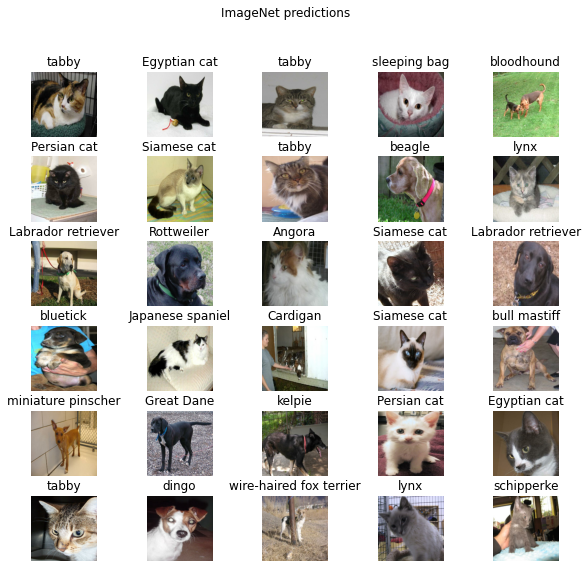

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [16]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [17]:
# 32 is the number of images, and 1280 is the number of neurons in the last layer
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [18]:
feature_extractor.trainable = False

In [19]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 40s 68ms/step - loss: 0.0560 - accuracy: 0.9810 - val_loss: 0.0356 - val_accuracy: 0.9873
Epoch 2/6
582/582 [==============================] - 39s 67ms/step - loss: 0.0289 - accuracy: 0.9902 - val_loss: 0.0304 - val_accuracy: 0.9910
Epoch 3/6
582/582 [==============================] - 39s 67ms/step - loss: 0.0246 - accuracy: 0.9914 - val_loss: 0.0312 - val_accuracy: 0.9905
Epoch 4/6
582/582 [==============================] - 39s 67ms/step - loss: 0.0219 - accuracy: 0.9931 - val_loss: 0.0310 - val_accuracy: 0.9912
Epoch 5/6
582/582 [==============================] - 39s 67ms/step - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.0312 - val_accuracy: 0.9903
Epoch 6/6
582/582 [==============================] - 39s 67ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0331 - val_accuracy: 0.9899


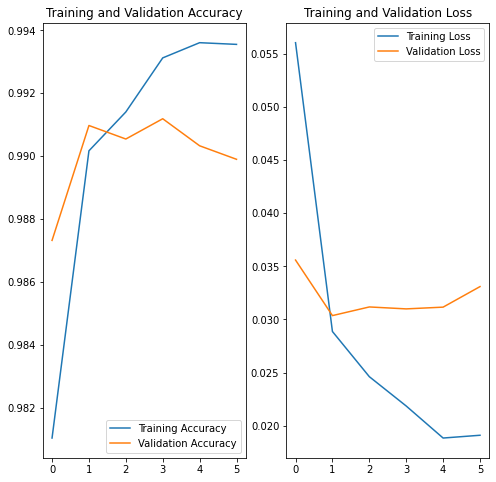

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# validation performance is better than training performance?

In [22]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [23]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog',
       'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog',
       'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog',
       'dog', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

In [24]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0]
Predicted labels:  [0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0]


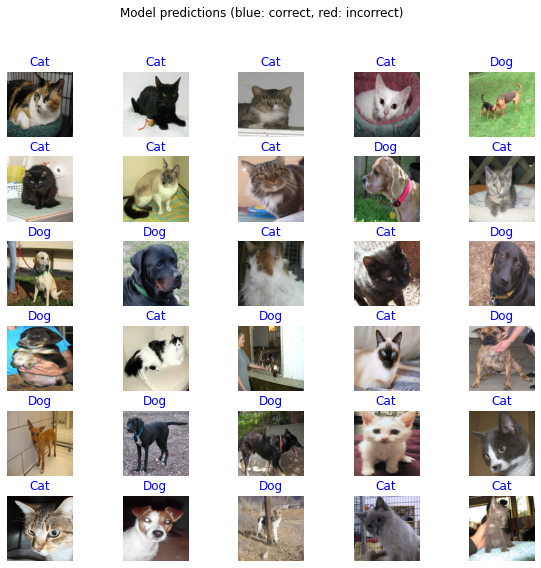

In [25]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")